In [47]:
import pandas as pd
import numpy as np
from drf import drf
from plotnine import *
#import importlib
#import sys
#sys.path.append("../")

#import dataset, metrics, plotting, config
#from models import cgan_model
import numpy as np
import random
import tensorflow.keras as keras
from sklearn.utils import resample

#importlib.reload(dataset)
#importlib.reload(metrics)
#importlib.reload(plotting)
#importlib.reload(config)
#importlib.reload(cgan_model)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

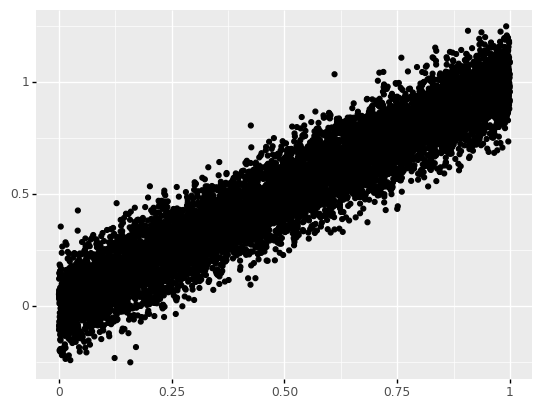

<ggplot: (379893957)>

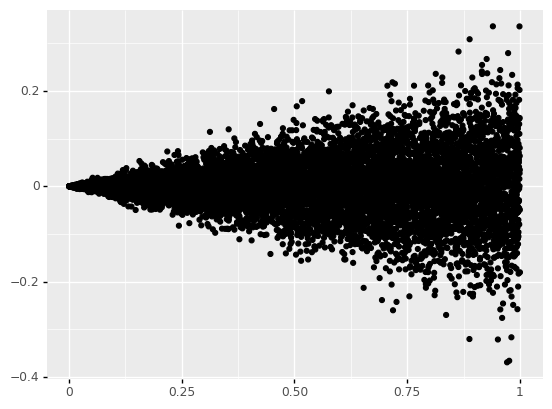

<ggplot: (299420133)>

In [49]:
# generate data
n = 10000
n_test = 200
p = 10
d = 2
sigma = 0.1
X = np.random.uniform(0, 1, size=(n, p))
Y = np.random.normal(0, 1, size=(n, d))*sigma
Y[:,0] = Y[:,0] + X[:,0] #mean shift of Y1 based on X1
Y[:,1] = Y[:,1] * X[:,1] #variance shift of Y2 based on X2

qplot(X[:,0], Y[:,0])
qplot(X[:,1], Y[:,1])

X_test = np.random.uniform(0, 1, size=(n_test, p))
#X = pd.DataFrame(X)
#Y = pd.DataFrame(Y)

In [55]:
import tensorflow.keras as keras
m = 50 # batch size
n_z = 2 # latent space size
encoder_dim = 5 # dim of encoder hidden layer
decoder_dim = 5 # dim of decoder hidden layer
decoder_out_dim = Y.shape[1]  
activ = 'relu'
optim = keras.optimizers.Adam(lr=0.001)
n_x = Y.shape[1]
n_y = X.shape[1]

In [56]:
## Explicitely define shape for the encoder
R = keras.layers.Input(shape=(n_x,))
C = keras.layers.Input(shape=(n_y,))

## Concatenate the input and the label for the CVAE
inputs = keras.layers.concatenate([R, C])

In [57]:
encoder_h = keras.layers.Dense(encoder_dim, activation=activ)(inputs)
mu = keras.layers.Dense(n_z, activation='linear')(encoder_h)
l_sigma = keras.layers.Dense(n_z, activation='linear')(encoder_h)
## Define the latent space - z layer
def sample_z(args):
    mu, l_sigma = args
    eps = keras.backend.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + keras.backend.exp(l_sigma / 2) * eps

In [63]:
z = keras.layers.Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])
# merge latent space with label
zc = keras.layers.concatenate([z, C])

TypeError: unsupported callable

In [ ]:
decoder_hidden = keras.layers.Dense(decoder_dim, activation=activ)
decoder_out = keras.layers.Dense(decoder_out_dim, activation='linear')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [ ]:
## Model will be trained on vae loss

def vae_loss(y_true, y_pred):
    recon = keras.backend.sum(keras.backend.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * keras.backend.sum(keras.backend.exp(l_sigma) + keras.backend.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * keras.backend.sum(keras.backend.exp(l_sigma) + keras.backend.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return keras.backend.sum(keras.backend.binary_crossentropy(y_true, y_pred), axis=-1)

# instantiate a the keras model class API
cvae = keras.models.Model([R, C], outputs)
encoder = keras.models.Model([R, C], mu)

d_in = keras.layers.Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = keras.models.Model(d_in, d_out)

In [61]:
## Compile function
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss], experimental_run_tf_function=False)

# compile and fit
n_epoch = 50
print(type(X))
print(type(Y))
cvae_hist = cvae.fit(x=[Y, X], y = Y, verbose = 1, batch_size=m, epochs=n_epoch).history

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.

In [98]:
def sampleCVAE(Xtest, nsample):
    S = np.zeros((Xtest.shape[0],Y.shape[1],nsample))
    for i in range(Xtest.shape[0]):
        Z = np.random.normal(size=(nsample, n_z))
        t = np.array([Xtest[i,:]]*Z.shape[0])
        Test = np.concatenate([Z,t], axis=1)
        SS = decoder.predict(Test)
        S[i,:,:] = np.transpose(SS,(1,0))
    return S


S = sampleCVAE(X_test,nsample=100)

In [99]:
S.shape

(200, 2, 100)

In [102]:
q1 = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, S)
q2 = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, S)
mC = np.apply_along_axis(lambda x: np.mean(x), 2, S)

In [104]:
q1.shape
q2.shape
mC.shape

(200, 2)

(200, 2)

(200, 2)

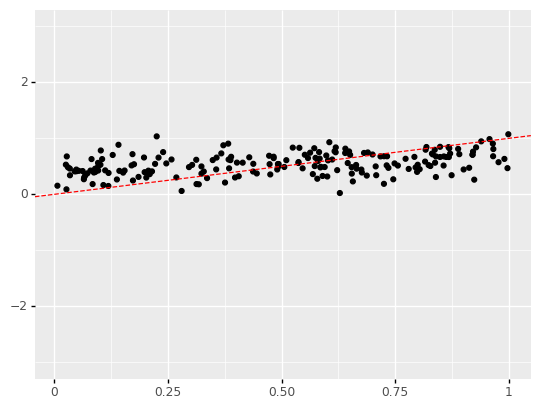

<ggplot: (8753330832889)>

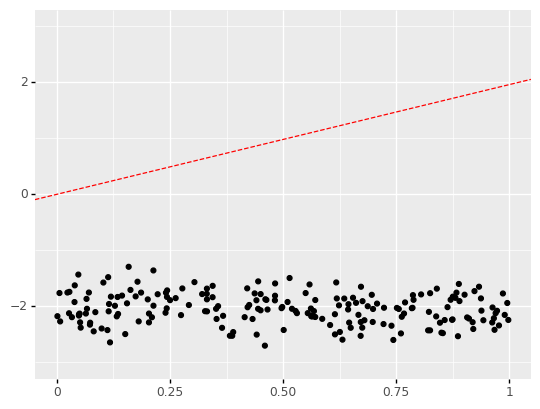

<ggplot: (8753330531633)>

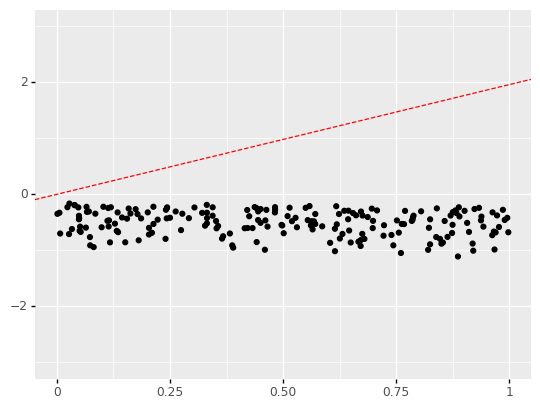

<ggplot: (8753330497249)>

In [110]:
(qplot(X_test[:,0], mC[:,0]) +
    geom_abline(slope=1, linetype='dashed', color='red') +
    ylim([-3, 3])
)
(qplot(X_test[:,1], q1[:,1]) +
    geom_abline(slope=1.96, linetype='dashed', color='red') + 
    ylim([-3, 3])
)
(qplot(X_test[:,1], q2[:,1]) +
    geom_abline(slope=1.96, linetype='dashed', color='red') + 
    ylim([-3, 3])
)

In [160]:
DRF = drf(min_node_size = 5, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
DRF.fit(X, Y)
DRF.info()
DRF_CART = drf(min_node_size = 5, num_trees = 2000, splitting_rule = "CART") #those are the default values
DRF_CART.fit(X, Y)
DRF_CART.info()

DRF forest object
Number of trees: 2000 
Number of training samples: 1000 
DRF forest object
Number of trees: 2000 
Number of training samples: 1000 


In [161]:
X_test = np.random.uniform(0, 1, size=(1000, p))


In [162]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
kernRBF = RBF(length_scale=0.1, length_scale_bounds=(1e-05,1))
kernConst = ConstantKernel()
gp_rbf = GaussianProcessRegressor(kernel = kernRBF)
gp_rbf.fit(X,Y)
mean_h = np.mean(Y, axis=0)
mean_h = np.array([mean_h])
cov_h = np.cov((Y.T-mean_h.T))

GaussianProcessRegressor(kernel=RBF(length_scale=0.1))

In [163]:
from sklearn.neighbors import KNeighborsRegressor
from random import choices
knn = KNeighborsRegressor(int(np.sqrt(X.shape[0])))
knn.fit(X, Y)
id = knn.kneighbors_graph(X_test)

KNeighborsRegressor(n_neighbors=31)

In [164]:
from sklearn.ensemble import RandomForestRegressor
forest_list = []
for i in range(Y.shape[1]):
    rf = RandomForestRegressor(random_state=0,n_estimators=2000)
    rf.fit(X,Y[:,i])
    forest_list.append(rf)
    
def predictRF(X):
    preds = np.zeros((X.shape[0], Y.shape[1]))
    for i in range(len(forest_list)):
        preds[:,i] = forest_list[i].predict(X)
    return preds
        
print(predictRF(X_test))

RandomForestRegressor(n_estimators=2000, random_state=0)

RandomForestRegressor(n_estimators=2000, random_state=0)

[[ 0.69275429 -0.23331808]
 [ 0.86240186 -0.03837616]
 [ 0.37829315 -0.02924105]
 ...
 [ 0.55113534  0.05573486]
 [ 0.7266648  -0.10368405]
 [ 0.76422048 -0.22499913]]


In [165]:
from models import cgan_model

dataset_config = config.DatasetConfig(scenario="benchmark_1", n_instance=1000)


exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, dec_gen=0, lr_disc=0.001, optim_gen="Adam", 
                             optim_disc="Adam", z_input_size=1),
    training=config.TrainingConfig(n_epochs=500, batch_size=20, n_samples=500),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [ ]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X, Y, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)

ypred_gan_test = cgan.predict(X)

/home/loris/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Epoch: 0 / dLoss: 0.7647894620895386 / gLoss: 0.6844152212142944
Epoch: 1 / dLoss: 0.7303500175476074 / gLoss: 0.7169578671455383
Epoch: 2 / dLoss: 0.5541328191757202 / gLoss: 0.8202114105224609
Epoch: 3 / dLoss: 0.6093621253967285 / gLoss: 0.8325842022895813
Epoch: 4 / dLoss: 0.5206870436668396 / gLoss: 0.9477299451828003
Epoch: 5 / dLoss: 0.6848083734512329 / gLoss: 0.7191147208213806
Epoch: 6 / dLoss: 0.5584093332290649 / gLoss: 0.947851836681366
Epoch: 7 / dLoss: 0.6746472716331482 / gLoss: 0.7524498105049133
Epoch: 8 / dLoss: 0.7060681581497192 / gLoss: 0.8304876089096069
Epoch: 9 / dLoss: 0.6258478760719299 / gLoss: 0.7819093465805054
Epoch: 10 / dLoss: 0.43138933181762695 / gLoss: 1.3146605491638184
Epoch: 11 / dLoss: 0.3913632333278656 / gLoss: 1.4039437770843506
Epoch: 12 / dLoss: 0.8326139450073242 / gLoss: 0.8738542795181274
Epoch: 13 / dLoss: 0.42281031608581543 / gLoss: 1.2868967056274414
Epoch: 14 / dLoss: 0.7877867221832275 / gLoss: 0.7922431230545044
Epoch: 15 / dLoss: 

In [ ]:

out_drf = DRF.predict(newdata = X_test, functional='mean')
out_cart = DRF_CART.predict(newdata = X_test, functional='mean')
out_homo = predictRF(X_test)
#out_gp_const = gp_const.predict(X_test)

out_gp_rbf = gp_rbf.predict(X_test)
out_gp_const = np.repeat(mean_h,[X_test.shape[0]],axis=0)

pred = pd.DataFrame()
pred['x'] = X_test[:,0]
pred['DRF_MMD'] = out_drf.mean[:,0]
pred['DRF_CART'] = out_cart.mean[:,0]
pred['HOMO'] = out_homo[:,0]
pred['GP_RBF'] = out_gp_rbf[:,0]
pred['KNN'] = knn.predict(X_test)[:,0]
pred['CGAN'] = cgan.predict(X_test)[:,0]
print(pred)
pred_long1 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long1['response'] = "Y1"
pred = pd.DataFrame()
pred['x'] = X_test[:,1]
pred['DRF_MMD'] = out_drf.mean[:,1]
pred['DRF_CART'] = out_cart.mean[:,1]
pred['HOMO'] = out_homo[:,1]
pred['GP_RBF'] = out_gp_rbf[:,1]
pred['KNN'] = knn.predict(X_test)[:,1]
pred['CGAN'] = cgan.predict(X_test)[:,1]
print(pred)
pred_long2 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long2['response'] = "Y2"

pred_long = pd.concat([pred_long1, pred_long2])
pred_long.to_csv("./data/output/pred_mean_vignette.csv")
print(pred_long)
#ggplot(pred_long) + facet_grid('response~method') + aes(x='x',y='pred') + geom_point() #+ geom_abline(linetype='dashed', color='red')# + geom_abline(linetype='dashed', color='red') 

In [ ]:
_, _, ypred_gan_sample_test = cgan.sample(X_test, exp_config.training.n_samples)
    #ypred_drf_sample_test  = DRF.predict(newdata = X_test_pd, functional = "sample", n=exp_config.training.n_samples).sample
    #ypred_drf_cart_sample_test  = DRF_CART.predict(newdata = X_test_pd, functional = "sample", n=exp_config.training.n_samples).sample
ypred_gp_rbf_sample_test = gp_rbf.sample_y(X_test, exp_config.training.n_samples)
#ypred_gp_const_sample_test = gp_const.sample_y(X_test, exp_config.training.n_samples)
ypred_knn_sample_test = np.zeros((X_test.shape[0],Y.shape[1],exp_config.training.n_samples))
for i in range(X_test.shape[0]):
        _ , indices = np.where(id[i,:].toarray()==1)
        ypred_knn_sample_test[i,:,:] = np.transpose(Y[choices(indices.tolist(),k=exp_config.training.n_samples),:], (1,0))
        
ypred_xgboost_sample_test = np.zeros((X_test.shape[0],Y.shape[1],exp_config.training.n_samples))
for i in range(X_test.shape[0]):
        #ypred_xgboost_sample_test[i,:,:] = np.transpose(np.random.multivariate_normal(out_xgboost[i,:], cov_h, exp_config.training.n_samples), (1,0))
        ypred_xgboost_sample_test[i,:,:] = out_xgboost[i,:] + resample(y_train-out_xgboost, replace=True, n_samples = X_test.shape[0])
ypred_dnn_sample_test = np.zeros((X_test.shape[0],Y.shape[1],exp_config.training.n_samples))
for i in range(X_test.shape[0]):
        ypred_dnn_sample_test[i,:,:] = out_dnn[i,:] + resample(y_train-out_dnn, replace=True, n_samples = X_test.shape[0])
#ypred_gp_const_sample_test = np.zeros((X_test.shape[0],Y.shape[1],exp_config.training.n_samples))
#for i in range(X_test.shape[0]):
#        ypred_gp_const_sample_test[i,:,:] = np.transpose(np.random.multivariate_normal(out_homo[i,:], cov_h, exp_config.training.n_samples), (1,0))

In [ ]:
out_MMD = DRF.predict(newdata = X_test, functional='quantile', quantiles=[0.1, 0.9])
out_CART = DRF_CART.predict(newdata = X_test, functional='quantile', quantiles=[0.1, 0.9])

pred = pd.DataFrame()
pred['x'] = X_test[:,0]
pred['DRF_MMD'] = out_MMD.quantile[:,0,0]
pred['DRF_CART'] = out_CART.quantile[:,0,0]
pred['HOMO'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gp_const_sample_test)[:,0]
pred['GP_RBF'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gp_rbf_sample_test)[:,0]
pred['KNN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_knn_sample_test)[:,0]
pred['CGAN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gan_sample_test)[:,0]
print(pred)
pred_long1 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long1['response'] = "Y1"
pred = pd.DataFrame()
pred['x'] = X_test[:,1]
pred['DRF_MMD'] = out_MMD.quantile[:,1,0]
pred['DRF_CART'] = out_CART.quantile[:,1,0]
pred['HOMO'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gp_const_sample_test)[:,1]
pred['GP_RBF'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gp_rbf_sample_test)[:,1]
pred['KNN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_knn_sample_test)[:,1]
pred['CGAN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.1), 2, ypred_gan_sample_test)[:,1]
print(pred)
pred_long2 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long2['response'] = "Y2"
pred_long = pd.concat([pred_long1, pred_long2])
pred_long.to_csv("./data/output/pred_quantile_01_vignette.csv")

#ggplot(pred_long) + facet_grid('response~method') + aes(x='x',y='pred') + geom_point() 

In [ ]:
pred = pd.DataFrame()
pred['x'] = X_test[:,0]
pred['DRF_MMD'] = out_MMD.quantile[:,0,1]
pred['DRF_CART'] = out_CART.quantile[:,0,1]
pred['HOMO'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gp_const_sample_test)[:,0]
pred['GP_RBF'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gp_rbf_sample_test)[:,0]
pred['KNN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_knn_sample_test)[:,0]
pred['CGAN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gan_sample_test)[:,0]
print(pred)
pred_long1 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long1['response'] = "Y1"
pred = pd.DataFrame()
pred['x'] = X_test[:,1]
pred['DRF_MMD'] = out_MMD.quantile[:,1,1]
pred['DRF_CART'] = out_CART.quantile[:,1,1]
pred['HOMO'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gp_const_sample_test)[:,1]
pred['GP_RBF'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gp_rbf_sample_test)[:,1]
pred['KNN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_knn_sample_test)[:,1]
pred['CGAN'] = np.apply_along_axis(lambda x: np.quantile(x, 0.9), 2, ypred_gan_sample_test)[:,1]
print(pred)
pred_long2 = pd.melt(pred, id_vars="x",  var_name = 'method', value_name='pred')
pred_long2['response'] = "Y2"
pred_long = pd.concat([pred_long1, pred_long2])
pred_long.to_csv("./data/output/pred_quantile_09_vignette.csv")

#ggplot(pred_long) + facet_grid('response~method') + aes(x='x',y='pred') + geom_point() 

In [ ]:
out = DRF.predict(newdata = X_test, functional='quantile', quantiles=[0.025, 0.975])
(qplot(X_test[:,1], out.quantile[:,1,1]) +
    geom_abline(slope=1.96, linetype='dashed', color='red') +
    geom_abline(slope=-1.96, linetype='dashed', color='red') +
    ylim([-3, 3])
)